In [ ]:
!pip install -q pytorchvideo evaluate

In [ ]:
pip install -q pyarrow==14.0.1

In [ ]:
pip install -q transformers --upgrade

In [ ]:
pip install -q torch==2.0.1 torchvision==0.15.2 --extra-index-url https://download.pytorch.org/whl/cu118 xformers==0.0.21

> # **Data Collection and Aggregation**

In [1]:
import os
import pandas as pd

root_path = "/kaggle/input/cctv-dataset"
folder_list = os.listdir(root_path)
label_list = [path for path in folder_list if not path.endswith((".csv"))]

total_df = pd.read_csv(os.path.join(root_path,"train.csv"))

total_df.reset_index(drop = True, inplace = True)
total_df['label'].value_counts()

label
normal      222
theft       156
fight       101
accident     97
Name: count, dtype: int64

> # **Data Splitting**

In [2]:
from sklearn.model_selection import train_test_split

def correct_file_path(file_name: str, root_path: str):
    return os.path.join(root_path, file_name.replace('\\', '/'))

def preprocess_meta_df(df, root_path, label2id):
    df.rename(columns={"video_name": "video_path"}, inplace=True)
    df['video_path'] = df['video_path'].apply(lambda x: correct_file_path(x, root_path))
    df['label'] = df['label'].apply(lambda x: label2id[x])
    return df

train_meta_df, test_meta_df = train_test_split(total_df, test_size=0.2, stratify=total_df['label'], random_state=42)

label_list = list(set(train_meta_df['label']))
class_labels = sorted(label_list)
label2id = {label: i for i, label in enumerate(class_labels)}
id2label = {i: label for label, i in label2id.items()}

print(f"Unique classes: {list(label2id.keys())}.")

train_meta_df = preprocess_meta_df(train_meta_df, root_path, label2id)
test_meta_df = preprocess_meta_df(test_meta_df, root_path, label2id)

print("Splitted data:", len(train_meta_df), len(test_meta_df))

Unique classes: ['accident', 'fight', 'normal', 'theft'].
Splitted data: 460 116


> #  **Model Selection**

In [ ]:
import torch
import pytorchvideo.data
from torch.utils.data import Dataset
from transformers import VideoMAEImageProcessor, VideoMAEForVideoClassification
from transformers import VivitImageProcessor, VivitModel, VivitForVideoClassification

from pytorchvideo.transforms import (
    ApplyTransformToKey,
    Normalize,
    RandomShortSideScale,
    RemoveKey,
    ShortSideScale,
    UniformTemporalSubsample,
)

from torchvision.transforms import (
    Compose,
    Lambda,
    RandomCrop,
    RandomHorizontalFlip,
    Resize,
)

model_checkpoint = "google/vivit-b-16x2-kinetics400"
image_processor = VivitImageProcessor.from_pretrained(model_checkpoint)
model = VivitForVideoClassification.from_pretrained(model_checkpoint, label2id=label2id, id2label=id2label, ignore_mismatched_sizes=True)

> # **Data Preprocessing and Cleaning**

In [4]:
class CustomVideoDataset(Dataset):
    def __init__(self, dataframe):
        self.dataframe = dataframe

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        row = self.dataframe.iloc[idx]
        video_path = row['video_path']
        label = row['label']
        return video_path, label

mean = image_processor.image_mean
std = image_processor.image_std

if "shortest_edge" in image_processor.size:
    height = width = image_processor.size["shortest_edge"]
else:
    height = image_processor.size["height"]
    width = image_processor.size["width"]

resize_to = (model.config.image_size, model.config.image_size)

num_frames_to_sample = model.config.num_frames
clip_duration = 8

train_transform = Compose(
    [
        ApplyTransformToKey(
            key="video",
            transform=Compose(
                [
                    UniformTemporalSubsample(num_frames_to_sample),
                    Lambda(lambda x: x / 255.0),
                    Normalize(mean, std),
                    RandomShortSideScale(min_size=256, max_size=320),
                    Resize(resize_to),
                    RandomHorizontalFlip(p=0.5),
                ]
            ),
        ),
    ]
)

val_transform = Compose(
    [
        ApplyTransformToKey(
            key="video",
            transform=Compose(
                [
                    UniformTemporalSubsample(num_frames_to_sample),
                    Lambda(lambda x: x / 255.0),
                    Normalize(mean, std),
                    Resize(resize_to),
                ]
            ),
        ),
    ]
)

train_custom_dataset = CustomVideoDataset(train_meta_df)
train_labeled_video_paths = [(video_path, {'label': label}) for video_path, label in train_custom_dataset]

test_custom_dataset = CustomVideoDataset(test_meta_df)
test_labeled_video_paths = [(video_path, {'label': label}) for video_path, label in test_custom_dataset]

> # **Data Loading**

/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


accident


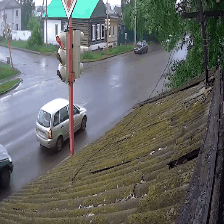

In [5]:
import imageio
import numpy as np
from IPython.display import Image

train_dataset = pytorchvideo.data.LabeledVideoDataset(
    labeled_video_paths =train_labeled_video_paths,
    clip_sampler=pytorchvideo.data.make_clip_sampler("random", clip_duration),
    decode_audio=False,
    transform=train_transform,
)

test_dataset = pytorchvideo.data.LabeledVideoDataset(
    labeled_video_paths =test_labeled_video_paths,
    clip_sampler=pytorchvideo.data.make_clip_sampler("uniform", clip_duration),
    decode_audio=False,
    transform=val_transform,
)

def unnormalize_img(img):
    img = (img * std) + mean
    img = (img * 255).astype("uint8")
    return img.clip(0, 255)

def create_gif(video_tensor, filename="sample.gif"):
    frames = []
    for video_frame in video_tensor:
        frame_unnormalized = unnormalize_img(video_frame.permute(1, 2, 0).numpy())
        frames.append(frame_unnormalized)
    kargs = {"duration": 0.5}
    imageio.mimsave(filename, frames, "GIF", **kargs)
    return filename

def display_gif(video_tensor, gif_name="sample.gif"):
    video_tensor = video_tensor.permute(1, 0, 2, 3)
    gif_filename = create_gif(video_tensor, gif_name)
    return Image(filename=gif_filename)

sample_video = next(iter(train_dataset))
video_tensor = sample_video["video"]
print(id2label[sample_video['label']])
display_gif(video_tensor)